In [1]:
%pip install tensorflow_io

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np

## Load Audio to Jupyter

In [3]:


def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        # speaker_id,version,gender,age,reason = speaker.split("-")
        #sp = speaker.split("-")
        #speaker_id = sp[0]
        #gender = sp[2]
        #age =sp[3]


        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate])
        #dataset.append([waveform, sample_rate, label, speaker_id, gender,age])

    return dataset



## Prepare Data

In [4]:
trainset_speechcommands_hungry = load_audio_files('./data/hungry', 'hungry')
trainset_speechcommands_burping = load_audio_files('./data/burping', 'burping')
trainset_speechcommands_tired = load_audio_files('./data/tired', 'tired')
trainset_speechcommands_belly_pain = load_audio_files('./data/belly_pain', 'belly_pain')
trainset_speechcommands_discomfort = load_audio_files('./data/discomfort', 'discomfort')
print(f'Length of hungry dataset: {len(trainset_speechcommands_hungry)}')
print(f'Length of burping dataset: {len(trainset_speechcommands_burping)}')
print(f'Length of tire dataset: {len(trainset_speechcommands_tired)}')
print(f'Length of belly_pain dataset: {len(trainset_speechcommands_belly_pain)}')
print(f'Length of discomfort dataset: {len(trainset_speechcommands_discomfort)}')

Length of hungry dataset: 392
Length of burping dataset: 8
Length of tire dataset: 34
Length of belly_pain dataset: 16
Length of discomfort dataset: 27


In [5]:
hungry_waveform = trainset_speechcommands_hungry[0][0]
hungry_sample_rate = trainset_speechcommands_hungry[0][1]
print(f'Yes Waveform: {hungry_waveform}')
print(f'Yes Sample Rate: {hungry_sample_rate}')
#print(f'Yes Label: {trainset_speechcommands_hungry[0][2]}')
#print(f'Yes ID: {trainset_speechcommands_hungry[0][3]}')

Yes Waveform: [-1.5897170e-06 -5.0467679e-06 -3.7197096e-06 ...  2.3651218e-04
  2.5615463e-04  1.6537076e-04]
Yes Sample Rate: 22050


## Waveform plot

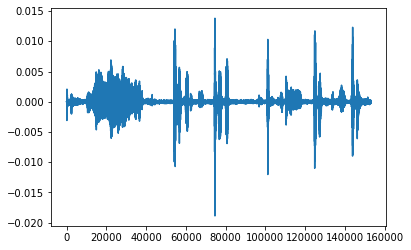

In [6]:
timescale = np.arange(hungry_waveform .shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, hungry_waveform)
plt.show()

In [7]:
import IPython.display as ipd
ipd.Audio(hungry_waveform, rate=hungry_sample_rate)

In [8]:
print(tf.shape(hungry_waveform))

tf.Tensor([153027], shape=(1,), dtype=int32)


## Spectrogram

In [9]:
def get_spectrogram(waveform):

    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    # zero_padding = tf.zeros([56000] - tf.shape(waveform), dtype=tf.float32)
    zero_padding = tf.zeros([60000] - tf.shape(waveform), dtype=tf.float32)
    
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)

    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)

    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

In [10]:
def get_spectrogram2(waveform,sample):
    fast_fourier_transf = np.fft.fft(waveform)
    
    magnitude = np.abs(fast_fourier_transf)
    
    frequency = np.linspace(0, sample, len(magnitude))
    
    left_mag = magnitude[:int(len(magnitude)/2)]
    left_freq = frequency[:int(len(frequency)/2)]
    
    n_fft = 2205
    
    hop_length = 220
    
    audio_stft = librosa.core.stft(waveform, hop_length=hop_length, n_fft=n_fft)
    
    # gathering the absolute values for all values in our audio_stft 
    spectrogram = np.abs(audio_stft)
    
    # Converting the amplitude to decibels
    log_spectro = librosa.amplitude_to_db(spectrogram)
    
    return log_spectro

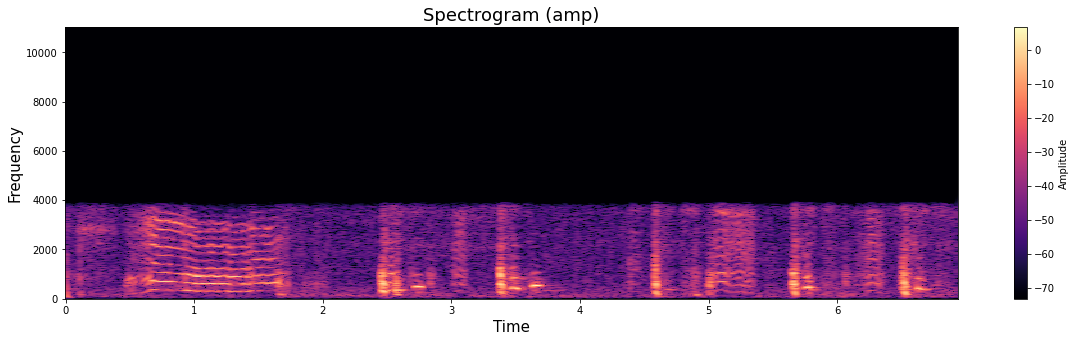

In [11]:
#spectrogram, spect = get_spectrogram(hungry_waveform)
log_sp = get_spectrogram2(hungry_waveform,hungry_sample_rate)
plt.figure(figsize=(20, 5))
librosa.display.specshow(log_sp,sr=hungry_sample_rate, x_axis='time',y_axis='hz',hop_length=220,cmap='magma')
plt.colorbar(label='Amplitude')
plt.title('Spectrogram (amp)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

##  Create Spectrogram image for classification

In [12]:
def create_images(dataset, label_dir,path,num):
    # make directory
    test_directory = f'./data/test_oneclass/{path}/{label_dir}/'
    train_directory = f'./data/train_oneclass/{path}/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)
    for i, data in enumerate(dataset):
        sample_rate = data[1]
        waveform = data[0]
        spectrogram = get_spectrogram2(waveform,sample_rate)
        
        # Split test and train images by 30%
        if i % 3 == 0:
            plt.imsave(f'./data/test_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')
        else:
            plt.imsave(f'./data/train_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')



In [13]:
create_images(trainset_speechcommands_hungry, 'hungry','hungry_one',0)
create_images(trainset_speechcommands_tired, 'non_hungry','hungry_one',1)
create_images(trainset_speechcommands_burping, 'non_hungry','hungry_one',2)
create_images(trainset_speechcommands_discomfort, 'non_hungry','hungry_one',3)
create_images(trainset_speechcommands_belly_pain, 'non_hungry','hungry_one',4)

In [14]:
create_images(trainset_speechcommands_tired, 'non_discomfort','discomfort_one',1)
create_images(trainset_speechcommands_burping, 'non_discomfort','discomfort_one',2)
create_images(trainset_speechcommands_discomfort, 'discomfort','discomfort_one',3)
create_images(trainset_speechcommands_belly_pain, 'non_discomfort','discomfort_one',4)

In [15]:
create_images(trainset_speechcommands_tired, 'tired','tired_one',1)
create_images(trainset_speechcommands_burping, 'non_tired','tired_one',2)
create_images(trainset_speechcommands_belly_pain, 'non_tired','tired_one',4)

In [16]:
create_images(trainset_speechcommands_burping, 'burping','burping_one',2)
create_images(trainset_speechcommands_belly_pain, 'non_burping','burping_one',4)

In [22]:
train_directory = './data/train_oneclass/hungry_one'
test_directory = './data/test_oneclass/hungry_one'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed = 321
    ,validation_split=0.2, subset='training')
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_directory, labels='inferred', label_mode='int', image_size=(256, 256)
#     ,validation_split=None, subset=None)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=0.2, subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 316 files belonging to 2 classes.
Using 253 files for training.
Found 316 files belonging to 2 classes.
Using 63 files for validation.
Found 161 files belonging to 2 classes.
['hungry', 'non_hungry']


In [5]:
type(test_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

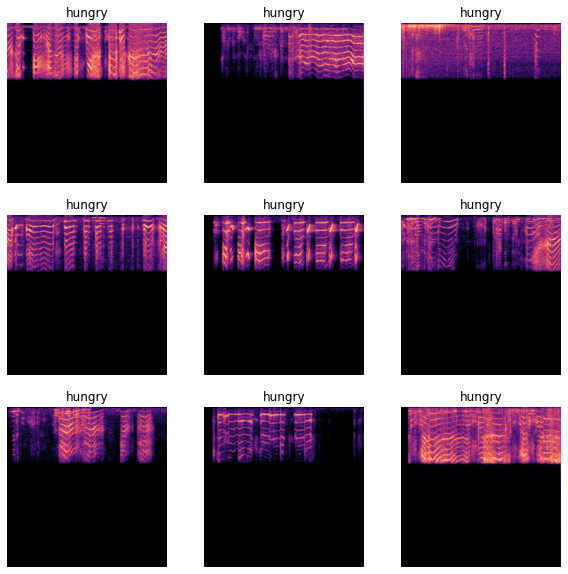

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create Model

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
num_classes = 2
img_height = 256
img_width = 256

In [9]:
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [10]:
class_count = np.array([254,49])

In [11]:
class_weights = {0:0, 1:0}

In [12]:
for i in range(num_classes):
    class_weights[i]=create_weight(303,num_classes,class_count[i])

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [40]:
learning_rate =  0.002

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate)
#optimizer = tf.keras.optimizers.Adadelta(learning_rate)
#optimizer = tf.keras.optimizers.Adamax(learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

In [41]:
# class_weights

In [42]:
# Set the epocks
epochs = 30
print('\nFitting:')
#class_weights = {0:20, 1:30, 2:20, 3:1, 4:15}
# Train the model.
#history = model.fit(train_ds, epochs=epochs,class_weight = class_weights)
history = model.fit(train_ds, epochs=epochs,validation_data=val_ds,class_weight = class_weights)
# history = model.fit(train_ds, epochs=epochs)


Fitting:
Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 1.1770 - accuracy: 0.5810 - val_loss: 0.6826 - val_accuracy: 0.8413
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.7218 - accuracy: 0.7866 - val_loss: 0.6898 - val_accuracy: 0.7460
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.7189 - accuracy: 0.5415 - val_loss: 0.7047 - val_accuracy: 0.3968
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.7072 - accuracy: 0.3755 - val_loss: 0.7198 - val_accuracy: 0.4921
Epoch 5/100
8/8 [==============================] - 8s 991ms/step - loss: 0.6714 - accuracy: 0.5099 - val_loss: 0.5656 - val_accuracy: 0.6667
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 0.6604 - accuracy: 0.5415 - val_loss: 0.7870 - val_accuracy: 0.2540
Epoch 7/100
8/8 [==============================] - 8s 988ms/step - loss: 0.6936 - accuracy: 0.3162 - val_loss: 0.7421 - val_accuracy: 0.3333
Epoch 8/100
8/8 [

KeyboardInterrupt: 

In [17]:
# score = model.evaluate(input_test, target_test, verbose=0)

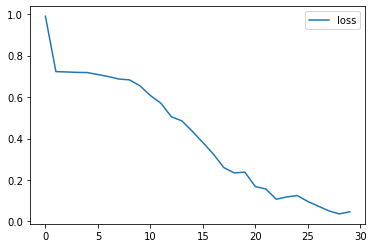

In [28]:
plt.plot(history.history['loss'],label = 'loss')
#plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

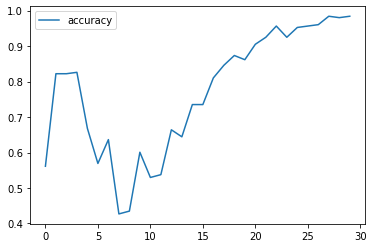

In [29]:
plt.plot(history.history['accuracy'],label = 'accuracy')
#plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.show()

In [30]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted 

In [31]:
correct = 0
batch_size = 0
sum_size = 0
count = 0
y_pred = []
y_true = []
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    sum_size = sum_size + batch_size
    pred = model.predict(X)
    #print(pred)
    for i in range(batch_size):
        predicted = np.argmax(pred[i], axis=-1)
        #predicted = binary_transform(pred[i])
        actual = Y[i]
        y_pred.append(predicted)
        y_true.append(actual)
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    #break

print(f'Number correct: {correct} out of {sum_size}')
print(f'Accuracy {correct / sum_size}')

Number correct: 116 out of 161
Accuracy 0.7204968944099379


<function matplotlib.pyplot.show(close=None, block=None)>

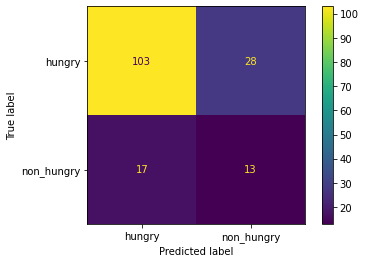

In [32]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       131
           1       0.32      0.43      0.37        30

    accuracy                           0.72       161
   macro avg       0.59      0.61      0.59       161
weighted avg       0.76      0.72      0.74       161

